# Use SX5E and bloomberg download data to get me started

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [47]:
#initial cleaning function
def clean_sheet(dataframe):
    adj=dataframe.dropna(axis=1,how='all')
    adj=dataframe.set_index(adj.columns[0]) #use stock tickers as the index
    return adj

In [2]:
plt.title


<function matplotlib.pyplot.title>

In [202]:
#pull the data from excel, form a dictionary of tab names and dataframes
tabs_to_grab=['Quarter','Date','Reported EPS','Comp EPS','Consensus EPS','50d MA','3d return','3d rel return','Volume','Momentum',
             'Revision','Market cap','PE','Property','Price']

data_dict={}

for s in tabs_to_grab:
    data_dict[s]=clean_sheet(pd.read_excel(r'C:\Users\Eric.Li\Documents\Post result data\2016-2018.xlsx',sheet_name=s))

In [203]:
# grab the price time series and transform it into the same datetime format; also generate abs_return, rel_return dataframe
price=data_dict["Price"].dropna(axis=1)
new_column=[i.strftime("%d/%b/%Y") for i in price.columns.tolist() if type(i)!=str]
price.columns=new_column


## Signal 2 - based on last quarter's standing

In [204]:
## grab the date 
date=data_dict["Date"].dropna(axis=1,how='all')
adj_date=date.fillna(pd.Timestamp('1900-1-1'))

In [205]:
## form the signal 2: separate date range into a unit of 3 months, evaluate the the top and bottom quartile values, use the
# dataframe for the next quarter to generate signals, and put them into long and short buckets
start_date=pd.Timestamp(2015,12,31)
end_date=pd.Timestamp(2018,3,31)
per='Q'


def signal2_build(date_df,return_df,start_date,end_date,top_quartile,bottom_quartile):
    dt_rng=pd.date_range(start_date,end_date,freq=per)
    long_list=[]
    short_list=[]
    for s in range(len(dt_rng)-2):
        rank_list=[]
        rank=return_df[(date_df>=dt_rng[s])&(date_df<=dt_rng[s+1])]
        signal=date_df[(date_df>=dt_rng[s+1])&(date_df<=dt_rng[s+2])]
        signal_value=return_df[(date_df>=dt_rng[s+1])&(date_df<=dt_rng[s+2])]
        for index,row in rank.iterrows():
            adj_row=row.dropna()
            for val in adj_row.values:
                rank_list.append(val)
        rank_series=pd.Series(rank_list)
        top=signal[signal_value>=np.percentile(rank_series,top_quartile)].dropna(axis=1,how='all').dropna(axis=0,how='all')
        bottom=signal[signal_value<=np.percentile(rank_series,bottom_quartile)].dropna(axis=1,how='all').dropna(axis=0,how='all')
        long_list.append(top)
        short_list.append(bottom)
    long_signal=pd.concat(long_list,axis=1)
    short_signal=pd.concat(short_list,axis=1)
    return long_signal, short_signal
                
long_signal,short_signal=signal2_build(adj_date,data_dict["3d rel return"],start_date,end_date,80,20)   


In [206]:
#Stack signals into a list of tuples (stocks, dates), convert dates into a common format of datetime
def signal2_stacking(signal):
    signal2_list=[]
    for index, row in signal.iterrows():
        adj_row=row.dropna()
        for s in adj_row.values:
            ts=(s - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's') 
            adj_time=datetime.utcfromtimestamp(ts).strftime("%d/%b/%Y") #transform the datetime into a common format
            signal2_list.append((adj_row.name,adj_time))
    return signal2_list

signal2_long_list=signal2_stacking(long_signal)
signal2_short_list=signal2_stacking(short_signal)

C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  import sys


In [207]:
# grab the price time series and transform it into the same datetime format; also generate abs_return, rel_return dataframe
price=data_dict["Price"].dropna(axis=1)
new_column=[i.strftime("%d/%b/%Y") for i in price.columns.tolist() if type(i)!=str]
price.columns=new_column

abs_return=price.diff(1,axis=1)/price
abs_return=abs_return.dropna(how='all',axis=1)
rel_return=abs_return - abs_return.iloc[-1]
rel_return=rel_return.dropna(how='all',axis=1)

In [208]:
# create a dictionary to have signal information (tuple) as keys and return data time series as values to make it easier to check
#; replace datetime with number of days post announcement to make it more comparable 
def signal2_return_dict(signal2_list,return_dataframe,holding):
    signal2_dict={}
    for s in signal2_list:
        return_series=return_dataframe.loc[s[0]]
        day0=return_series.index.tolist().index(s[1]) #index of day 0
        target_series=return_series.iloc[day0:day0+min(holding, len(return_series[day0:]))]
        target_series.index=range(min(holding, len(return_series[day0:]))) #replace datetime with number of days post announcement
        target_series.name=s
        signal2_dict[s]=target_series
    return signal2_dict

In [212]:
# obtain the dataframe of return time series for the signal stocks, take the signal_return_dict function
def signal2_return_df(signal2_list,return_dataframe,holding):
    return_series_list=[]
    return_dict=signal2_return_dict(signal2_list,return_dataframe,holding)
    for index,key in return_dict.items():
        return_series_list.append(key)
    return_df=pd.concat(return_series_list,axis=1)
    return_df=return_df.dropna(how='any',axis=1) #drop stocks with limited history to make it more comparable
    return return_df

long_abs_return_df=signal2_return_df(signal2_long_list,abs_return,130)
long_rel_return_df=signal2_return_df(signal2_long_list,rel_return,130)
short_abs_return_df=signal2_return_df(signal2_short_list,abs_return,130)
short_rel_return_df=signal2_return_df(signal2_short_list,rel_return,130)

In [214]:
# List of signals and cumulative returns for the long book
long_ind_abs_return=long_abs_return_df.iloc[3:].cumsum(axis=0).iloc[-1]
long_ind_abs_return

long_ind_rel_return=long_rel_return_df.iloc[3:].cumsum(axis=0).iloc[-1]
long_ind_rel_return

ABI BB    29/Jul/2016   -0.218504
          04/May/2017   -0.045630
          27/Jul/2017   -0.163069
AD NA     01/Jun/2016   -0.137833
          25/Aug/2016   -0.156155
ADS GY    08/Mar/2017    0.044323
ALV GY    05/Aug/2016    0.106821
          16/Feb/2017    0.090799
ASML NA   18/Jan/2017    0.014859
          19/Jul/2017    0.101714
BAYN GY   27/Jul/2016   -0.010842
BN FP     28/Jul/2016   -0.230495
CRH ID    25/Aug/2016   -0.019996
DG FP     29/Jul/2016   -0.118322
          07/Feb/2017    0.069380
DPW GY    11/May/2016    0.063364
          03/Aug/2016    0.058724
DTE GY    11/May/2017   -0.149851
          03/Aug/2017   -0.158832
ENEL IM   28/Jul/2016   -0.103957
ENGI FP   02/Mar/2017    0.090637
ENI IM    01/Mar/2017   -0.136999
          28/Jul/2017    0.053941
EOAN GY   09/Aug/2017   -0.144026
FRE GY    03/May/2017   -0.101799
GLE FP    03/Aug/2016    0.308336
          03/Nov/2016    0.157413
IBE SQ    27/Apr/2016   -0.015499
          22/Feb/2017    0.086004
INGA NA   03/A

In [215]:
# List of signals and cumulative returns for the short book
short_ind_abs_return=short_abs_return_df.iloc[3:].cumsum(axis=0).iloc[-1]
short_ind_abs_return

short_ind_rel_return=short_rel_return_df.iloc[3:].cumsum(axis=0).iloc[-1]
short_ind_rel_return

ABI BB    28/Oct/2016   -0.163830
          02/Mar/2017   -0.023879
AD NA     17/Nov/2016   -0.121419
          09/Aug/2017    0.016639
ADS GY    03/Nov/2016    0.122706
AI FP     28/Jul/2017    0.087042
AIR FP    28/Apr/2016    0.012325
          27/Jul/2017    0.180000
ASML NA   20/Apr/2016    0.097056
BAS GY    29/Apr/2016    0.142328
          24/Feb/2017   -0.077816
BAYN GY   26/Apr/2016   -0.130387
          22/Feb/2017    0.022222
          27/Jul/2017   -0.058033
BBVA SQ   28/Apr/2016    0.045128
BMW GY    03/May/2016    0.021526
BNP FP    07/Feb/2017    0.137253
DAI GY    22/Apr/2016    0.048176
          02/Feb/2017   -0.165583
DBK GY    27/Jul/2016    0.325159
          27/Jul/2017   -0.023172
DG FP     28/Jul/2017    0.094173
DPW GY    08/Mar/2017    0.106085
DTE GY    02/Mar/2017   -0.056574
EI FP     29/Jul/2016   -0.149167
          28/Jul/2017    0.009061
ENEL IM   10/Nov/2016    0.069813
ENGI FP   28/Jul/2016   -0.309172
          10/Nov/2016    0.022195
ENI IM    29/A

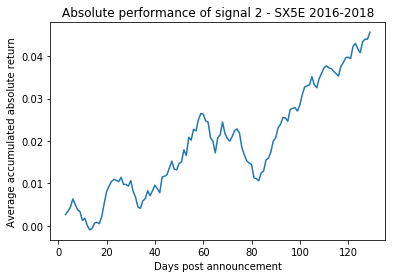

In [216]:
# Performance analytics
# 1. aggregate abs/rel performance over time
def perf_chart(return_df,xlabel,ylabel,title):
    cum_return=return_df.mean(axis=1).cumsum()
    plt.plot(cum_return)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
    
perf_chart(long_abs_return_df.iloc[3:], xlabel="Days post announcement",
           ylabel="Average accumulated absolute return",title="Absolute performance of signal 2 long - SX5E 2016-2018")

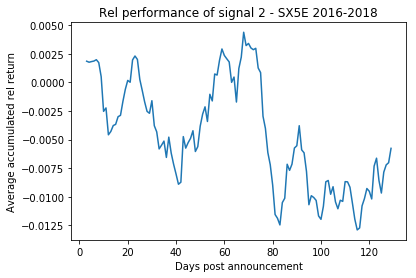

In [217]:
perf_chart(long_rel_return_df.iloc[3:], xlabel="Days post announcement",
           ylabel="Average accumulated rel return",title="Relative performance of signal 2 long - SX5E 2016-2018")

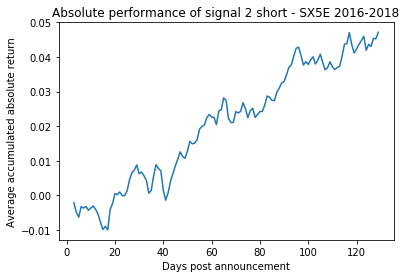

In [218]:
perf_chart(short_abs_return_df.iloc[3:], xlabel="Days post announcement",
           ylabel="Average accumulated absolute return",title="Absolute performance of signal 2 short - SX5E 2016-2018")

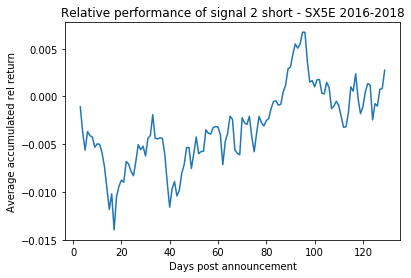

In [220]:
perf_chart(short_rel_return_df.iloc[3:], xlabel="Days post announcement",
           ylabel="Average accumulated rel return",title="Relative performance of signal 2 short - SX5E 2016-2018")